# Лінійна регресія: перенавчання та регуляризація

У цьому завдання ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх осередках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "__Відповідь:__".

In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, в якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знайомство з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [65]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 - немає свята, 1 - є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

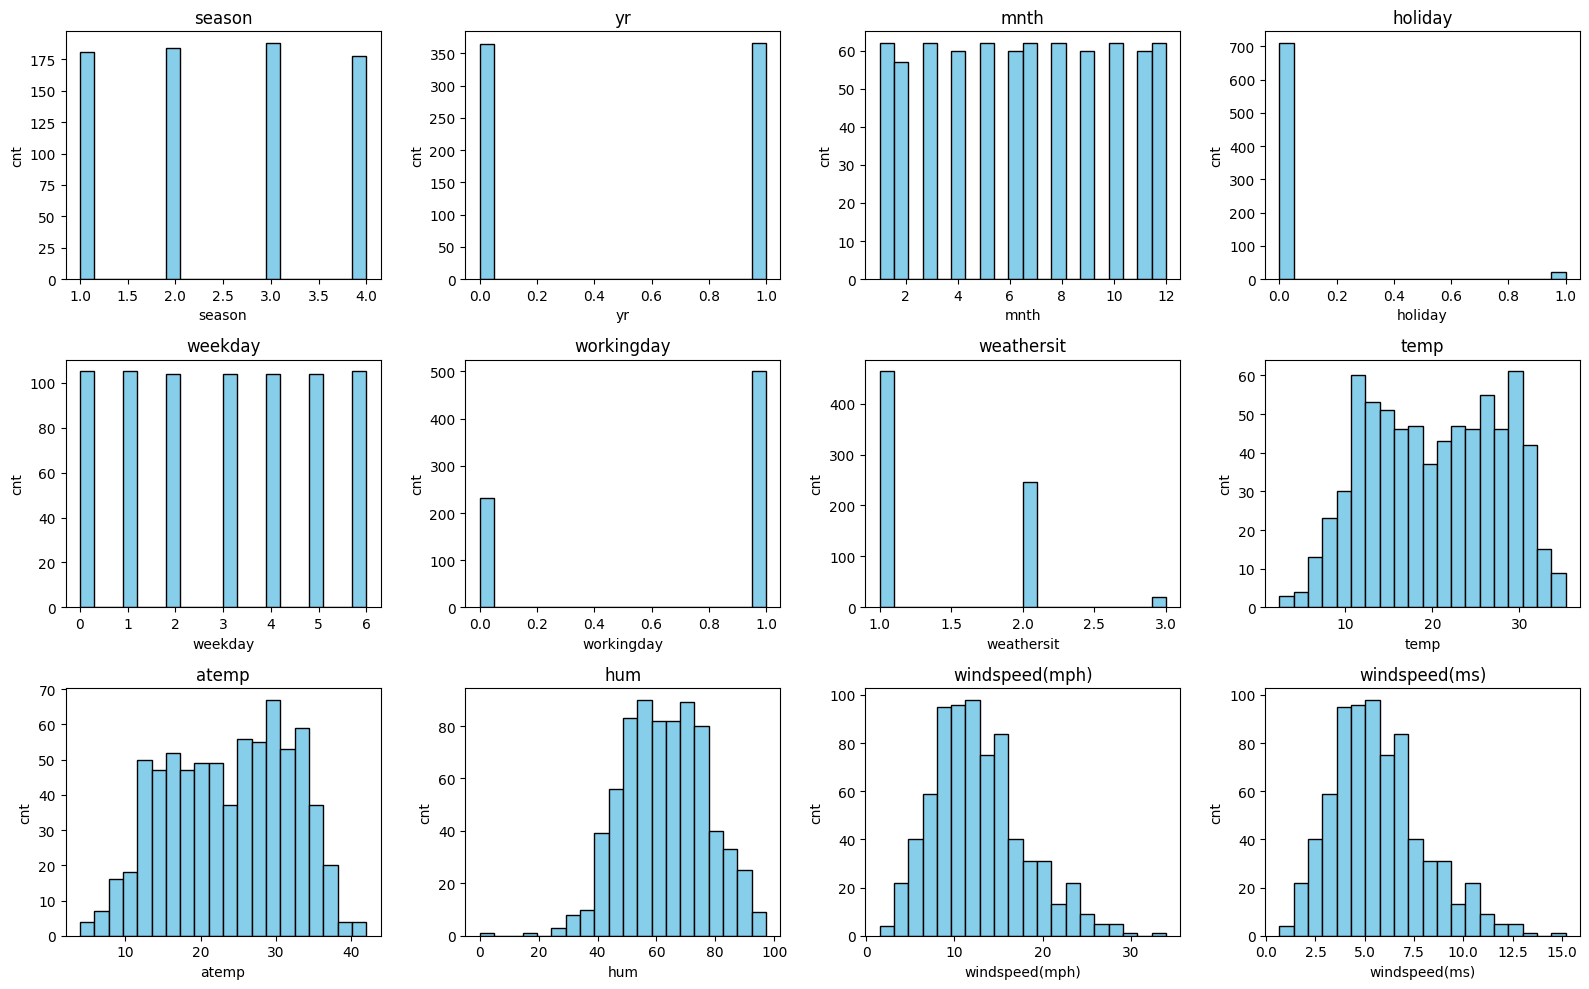

In [66]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 
              'weathersit','temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for i, attribute in enumerate(attributes):
    row = i // 4
    col = i % 4

    axes[row, col].hist(df[attribute], bins=20, color='skyblue', edgecolor='black')
    axes[row, col].set_title(attribute)
    axes[row, col].set_xlabel(attribute)
    axes[row, col].set_ylabel('cnt')

plt.tight_layout()
plt.show()


__Питання:__
1. Який характер залежності кількості прокатів від місяця?
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно

__Відповідь:__
1. Квадратична залежність
2. Температура, вологість, швидкість вітру

## Завдання 2

Давайте строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останньою за допомогою методу `corrwith`.

In [67]:
df.iloc[:, 0:12].corrwith(df["cnt"], axis=0)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

За графіками видно, деякі ознаки схожі друг на друга. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [68]:
df[["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознаки

In [69]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [70]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [71]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [72]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
model.coef_

array([ 5.70869840e+02,  1.02196484e+03, -1.41305750e+02, -8.67602382e+01,
        1.37229903e+02,  5.63900559e+01, -3.30233045e+02,  3.67465276e+02,
        5.85564375e+02, -1.45603647e+02,  1.24604063e+13, -1.24604063e+13])

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних та виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [73]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

for feature, weight in zip(df.columns, model.coef_):
    print(feature, weight)

season 570.869840420185
yr 1021.9648369366325
mnth -141.3057498128626
holiday -86.7602382288565
weekday 137.22990306303458
workingday 56.39005586999093
weathersit -330.2330450008552
temp 367.4652763382111
atemp 585.5643746373447
hum -145.6036472997277
windspeed(mph) 12460406274500.414
windspeed(ms) -12460406274698.863


Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [74]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()
lasso_reg.fit(X, y)

for feature, weight in zip(df.columns[:-1], lasso_reg.coef_):
    print(feature, weight)

season 560.2416160308865
yr 1019.4634940657198
mnth -128.73062703678733
holiday -86.15278133371098
weekday 137.347893904963
workingday 55.212370641356785
weathersit -332.3698569623486
temp 376.36323620969347
atemp 576.5307935045563
hum -144.12915500348578
windspeed(mph) -197.13968940248455
windspeed(ms) -2.805103823944435e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [75]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge()
ridge_reg.fit(X, y)

for feature, weight in zip(df.columns[:-1], ridge_reg.coef_):
    print(feature, weight)

season 563.0645722520163
yr 1018.948378787527
mnth -131.87332028247576
holiday -86.74609799709245
weekday 138.0051111787192
workingday 55.90311037506427
weathersit -332.3497884990726
temp 386.45788919191114
atemp 566.3470470600643
hum -145.07132729867305
windspeed(mph) -99.25944108182756
windspeed(ms) -99.25944115430536


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак. Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з 'alphas' навчіть регресор 'Lasso' і запишіть ваги список 'coefs_lasso', а потім навчіть 'Ridge' і запишіть ваги в список 'coefs_ridge'. Конвертуйте отримані списки в `np.array`.

In [76]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    ridge = Ridge(alpha=alpha)
    lasso.fit(X, y)
    ridge.fit(X, y)
    coefs_lasso.append(lasso.coef_)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

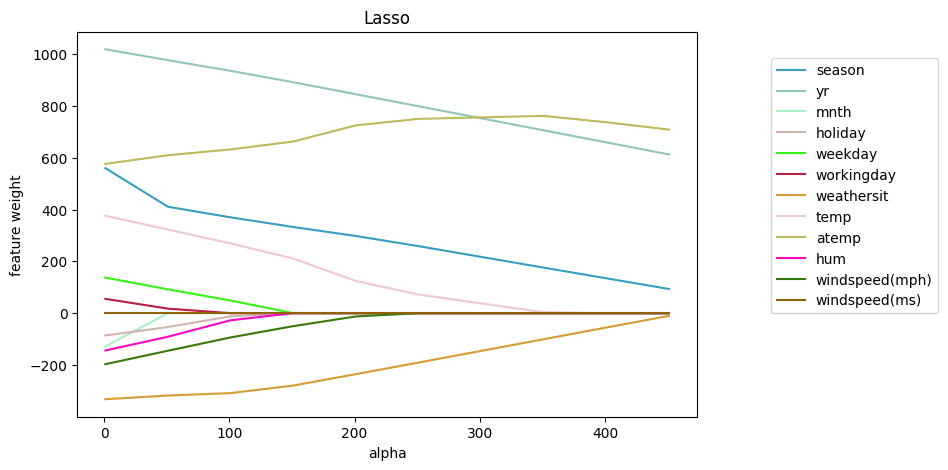

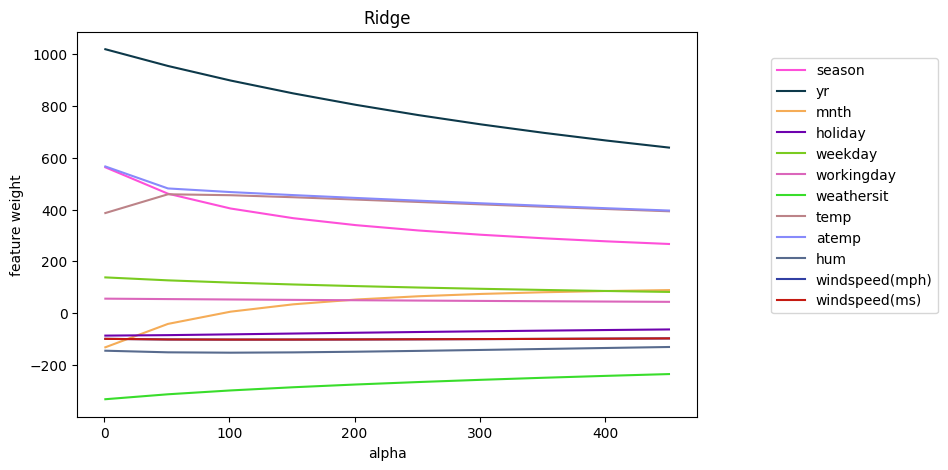

In [77]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

__Відповідь:__
1. Lasso
1. Ваги знизяться до 0. Чим більше значення альфа, тим сильніше штрафується величина суми абсолютних значень ваги.
1. Lasso може виключити ознаку windspeed при досить великому значенні alpha. Ridge не обов'язково виключатиме ознаку повністю
1. Lasso


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель робитиме передбачення нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ по рядках `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [78]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = data.alphas_
    y = [el.mean() for el in data.mse_path_]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha =  6
season 570.869840420185
yr 1021.9648369366325
mnth -141.3057498128626
holiday -86.7602382288565
weekday 137.22990306303458
workingday 56.39005586999093
weathersit -330.2330450008552
temp 367.4652763382111
atemp 585.5643746373447
hum -145.6036472997277
windspeed(mph) 12460406274500.414
windspeed(ms) -12460406274698.863


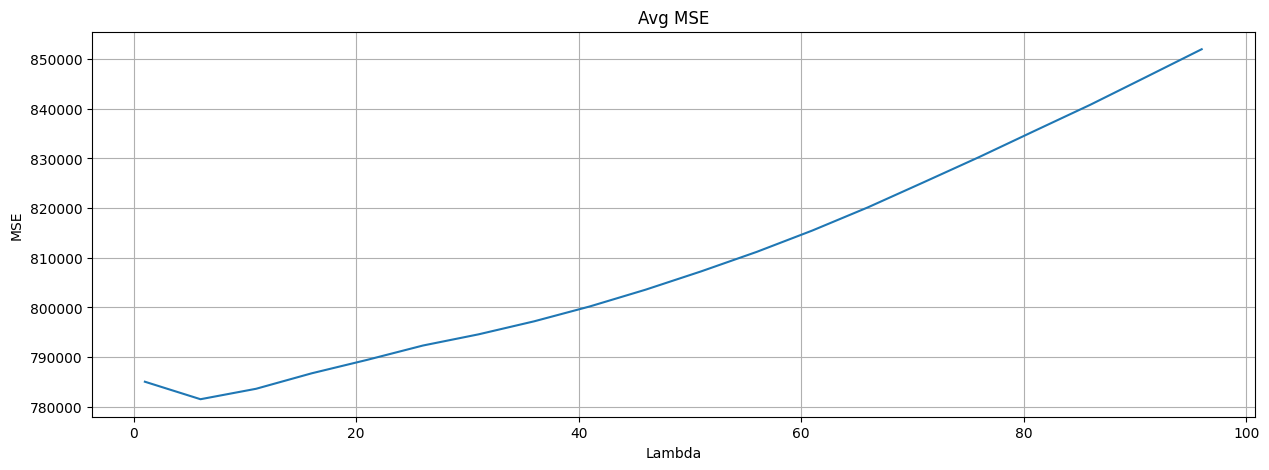

In [79]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
print('Alpha = ', regressor.alpha_)
for feature, weight in zip(df.columns, model.coef_):
    print(feature, weight)
create_plot(regressor, 'Avg MSE', 'Lambda', 'MSE')

Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцям).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Alpha = 6, MSE = 733725.760405224
Alpha = 1, MSE = 799433.1673691705
Alpha = 51, MSE = 796979.8955193633


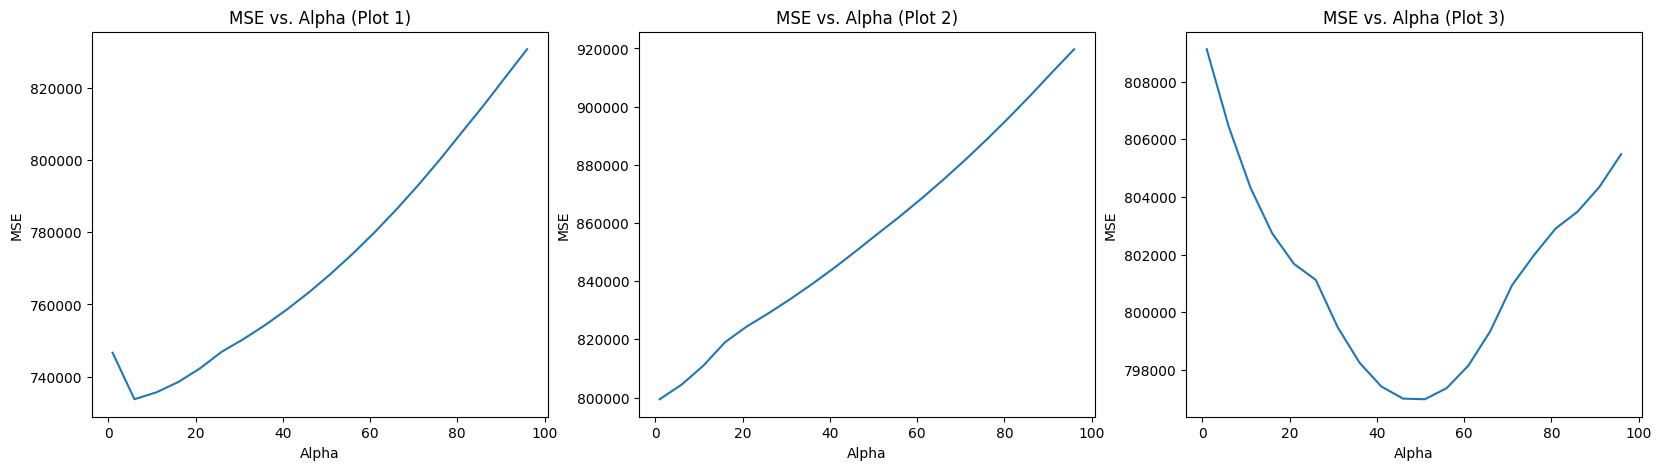

In [80]:
alphas = regressor.alphas_
mse = regressor.mse_path_
idx = np.argmin(mse, axis=0)
min_mse = mse.min(axis=0)

print('Alphas with minimum MSE:')
for i, m in zip(idx, min_mse):
    print(f'Alpha = {alphas[i]}, MSE = {m}')

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i in range(len(mse.T)):
    axs[i].plot(alphas, mse.T[i])
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('MSE')
axs[2].set_xlabel('Alpha')
axs[2].set_ylabel('MSE')
axs[0].set_title('MSE vs. Alpha (Plot 1)')
axs[1].set_title('MSE vs. Alpha (Plot 2)')
axs[2].set_title('MSE vs. Alpha (Plot 3)')
plt.show()

На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__
Чим більше температура, тим більше взятих велосипедів в прокат.

In [81]:
feature_names = df.columns.tolist()
coefficients = regressor.coef_
feature_coef_pairs = list(zip(feature_names, coefficients))
sorted_feature_coef_pairs = sorted(feature_coef_pairs, key=lambda x: abs(x[1]), reverse=True)
top_4_features = sorted_feature_coef_pairs[:4]

for feature, coef in top_4_features:
    print(f"Feature: {feature}, Coefficient: {coef}")



Feature: yr, Coefficient: 1015.0602226430599
Feature: atemp, Coefficient: 581.3969310654986
Feature: season, Coefficient: 532.0189828413535
Feature: temp, Coefficient: 370.6798550300334


#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__
Збільшення показника ознаки приводить до зменшення кількості взятих велосипедів в прокат.

In [82]:

negative_coefficients = [pair for pair in feature_coef_pairs if pair[1] < 0]
sorted_negative_coefficients = sorted(negative_coefficients, key=lambda x: abs(x[1]), reverse=True)
top_3_negative_features = sorted_negative_coefficients[:3]

for feature, coef in top_3_negative_features:
    print(f"Feature: {feature}, Coefficient: {coef*(-1)}")


Feature: weathersit, Coefficient: 330.5598567399815
Feature: windspeed(mph), Coefficient: 191.7714084713481
Feature: hum, Coefficient: 140.00740550068872


#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

In [83]:
close_to_zero_coefficients = [pair for pair in feature_coef_pairs if abs(pair[1]) < 1e-3]
for feature, coef in close_to_zero_coefficients:
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: windspeed(ms), Coefficient: -2.6856977917781423e-08


__Відповідь:__
Ознака windspeed впливає на попит, проте вона близька до нуля, бо дублює іншу ознаку

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, наскільки можна не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто відзначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів (1, 2, максимум 3), тому що для кожної допустимої комбінації нам доводиться кілька разів навчати модель. Такий процес займає багато часу, особливо якщо потрібно навчатися великих обсягах даних.